# Spam Classification Using Supervised Learning: A Model Comparison

### Darwhin Gomez

#### November 20, 2025

Spam detection is an essential task in digital communication, and supervised machine learning provides a reliable way to classify messages as spam or ham based on learned patterns. Using the UCI Spambase dataset, which contains numerical features derived from email content, this project compares multiple supervised learning algorithms to evaluate their ability to accurately detect spam. To ensure fair and robust model evaluation, we apply ten-fold cross-validation during training to identify the most effective models. The goal is to understand how different machine learning approaches perform on structured text-based features and determine which methods provide the strongest predictive accuracy for spam classification.


We will begin by loading the necessary libraries and the dataset.


In [1]:
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import (
    make_scorer,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from xgboost import XGBClassifier

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display

In [2]:
# Load dataset
spambase = fetch_ucirepo(id=94)
X = spambase.data.features
y = spambase.data.targets
spambase = fetch_ucirepo(id=94)
X = spambase.data.features
y = spambase.data.targets
X_clean = X.copy()
X_clean.columns = (
    X_clean.columns.str.replace("[", "LPAREN_", regex=False)
    .str.replace("]", "_RPAREN", regex=False)
    .str.replace("<", "LT_", regex=False)
    .str.replace(">", "_GT", regex=False)
    .str.replace("(", "_OPAREn", regex=False)
    .str.replace(")", "_CPAREN", regex=False)
)

# Use this cleaned version for all modeling
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y.squeeze(), test_size=0.25, random_state=42, stratify=y
)


# Use this cleaned version for all modeling
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y.squeeze(), test_size=0.25, random_state=42, stratify=y
)

Before building any predictive models, it is important to explore the structure and characteristics of the Spambase dataset. We begin by examining the overall dimensions of the data to understand how many observations and features are available for analysis. We then study the distribution of the variables, looking for skewed features, unusual ranges, or patterns that may influence model behavior. Because many features in Spambase represent word or character frequencies, we also check for strong correlations between predictors, as highly correlated inputs can affect certain algorithms more than others. Finally, we inspect the distribution of the target variable to determine the balance between spam and non-spam messages. Understanding these aspects of the dataset helps guide preprocessing decisions and provides context for interpreting model performance later in the analysis.


In [3]:
print(
    "Xtrain-shape|Xtest-sahpe\n============|===========\n",
    X_train.shape,
    " ",
    X_test.shape,
)
print(
    "ytrain-shape|ytest-sahpe\n============|===========\n",
    y_train.shape,
    "  ",
    y_test.shape,
)

Xtrain-shape|Xtest-sahpe
============|===========
 (3450, 57)   (1151, 57)
ytrain-shape|ytest-sahpe
============|===========
 (3450,)    (1151,)


In [4]:
train_bal = y_train.squeeze().value_counts(normalize=True) * 100
test_bal = y_test.squeeze().value_counts(normalize=True) * 100
print(
    f"The training set class distribution (%):\n{train_bal}\nthe testing set class distribution (%):\n{test_bal}"
)

The training set class distribution (%):
Class
0    60.608696
1    39.391304
Name: proportion, dtype: float64
the testing set class distribution (%):
Class
0    60.556038
1    39.443962
Name: proportion, dtype: float64


We see that the class distribution is fairly balanced in both the training and testing sets, with approximately 60% of the messages labeled as non-spam (ham) and 40% labeled as spam. This balance is beneficial for model training, as it helps prevent bias towards one class and allows the models to learn patterns for both spam and ham effectively.


Here I have created an interactive plot to show the disrubution of each predictor variable.


In [5]:
df = X_clean.copy()
df["spam"] = y.squeeze()

# Dropdown widget for selecting a feature
feature_selector = widgets.Dropdown(
    options=list(df.columns[:-1]), description="Feature:"  # excluding spam column
)


def plot_feature(feature):
    plt.figure(figsize=(8, 4))
    plt.hist(df[feature], bins=30, color="grey", edgecolor="black")
    plt.title(f"Distribution of {feature}")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.show()


widgets.interact(plot_feature, feature=feature_selector)

interactive(children=(Dropdown(description='Feature:', options=('word_freq_make', 'word_freq_address', 'word_f…

<function __main__.plot_feature(feature)>

Here we calculate the correlation of each feature with the target variable (spam vs. non-spam) to identify which predictors are most strongly associated with spam classification. Features with higher absolute correlation values may provide more informative signals for distinguishing between spam and ham messages. This analysis helps prioritize variables for model training and can guide feature selection or engineering efforts to improve classification performance. We plot the correlations using a horizontal bar chart to visualize the strength and direction of each feature's relationship with the spam target.


In [6]:
df_corr = X_clean.copy()
df_corr["spam"] = y.squeeze()

# Compute correlations with the target variable
target_corr = df_corr.corr()["spam"].sort_values(ascending=False)

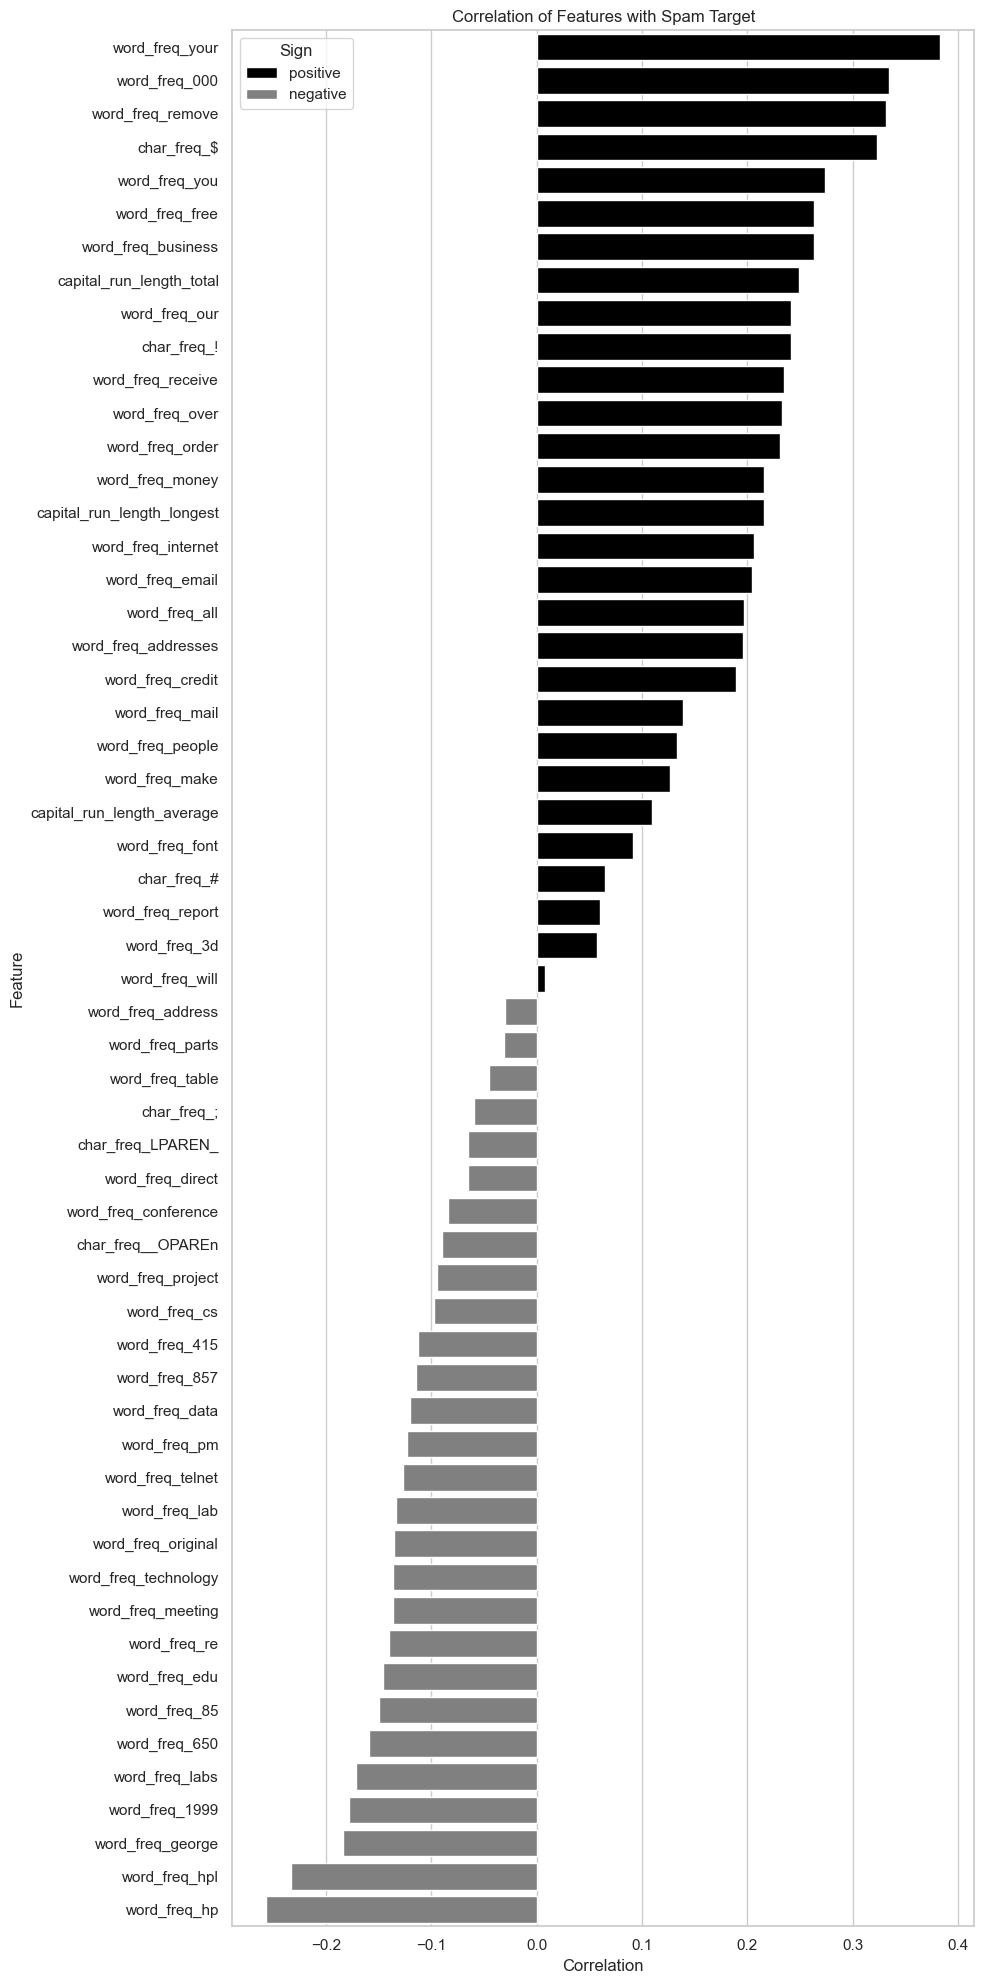

In [145]:
# Remove the trivial corr(spam, spam) entry
target_corr = target_corr.drop("spam")

# Prepare for plotting
corr_df = pd.DataFrame(
    {
        "Feature": target_corr.index,
        "Correlation": target_corr.values,
        "Sign": ["positive" if v > 0 else "negative" for v in target_corr.values],
    }
)

# Plot
plt.figure(figsize=(10, 20))
sns.barplot(
    data=corr_df,
    x="Correlation",
    y="Feature",
    hue="Sign",
    palette={"positive": "black", "negative": "grey"},
)
plt.title("Correlation of Features with Spam Target")
plt.xlabel("Correlation")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

The correlation analysis shows that several word and character frequency features are moderately predictive of spam, with terms like “your,” “000,” “remove,” and the presence of special characters such as $ appearing more often in spam messages. Conversely, features associated with technical or professional communication tend to correlate negatively with spam, indicating legitimate email content. Although none of the correlations are very strong individually, the pattern suggests that the dataset contains useful signals distributed across many features, which supports the use of supervised learning models to capture both linear and nonlinear relationships.


## Preprocessing

Before training the models, the data must be preprocessed to ensure that all algorithms operate on comparable input scales. The Spambase dataset contains numeric frequency-based features with substantial right skew and differing ranges, so standardization is an important step for models that rely on distance metrics or gradient-based optimization. In this stage, we apply StandardScaler to transform the features so that each has mean 0 and standard deviation 1. This helps stabilize the training process for algorithms such as logistic regression, support vector machines, and neural methods, while also ensuring fair comparison across models. Tree-based models are less sensitive to feature scaling but can still benefit from consistent preprocessing. After scaling, the processed training and test sets are ready for cross-validation and model fitting.


In [7]:
# Initialize scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_clean.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_clean.columns)

# Confirm scaling
X_train_scaled.describe().round(3).head(3)

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,word_freq_conference,char_freq_;,char_freq__OPAREn,char_freq_LPAREN_,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total
count,3450.0,3450.0,3450.0,3450.0,3450.0,3450.0,3450.0,3450.0,3450.0,3450.0,...,3450.0,3450.0,3450.0,3450.0,3450.0,3450.0,3450.0,3450.0,3450.0,3450.0
mean,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,0.0,...,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,-0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


### 10 fold Cross Validation

To ensure robust model evaluation and mitigate overfitting, we implement 10-fold cross-validation during model training. This technique involves partitioning the training dataset into 10 equal subsets, or "folds." In each iteration, one fold is held out as a validation set while the remaining nine folds are used to train the model. This process is repeated 10 times, with each fold serving as the validation set exactly once. By averaging the performance metrics across all folds, we obtain a more reliable estimate of how well each model generalizes to unseen data. This approach helps identify models that perform consistently well and reduces the likelihood of selecting a model that excels only on a specific subset of the data.


In [8]:
# Define 10-fold CV
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Define scorers
scorers = {
    "Accuracy": make_scorer(accuracy_score),
    "Precision": make_scorer(precision_score),
    "Recall": make_scorer(recall_score),
    "F1": make_scorer(f1_score),
}

## Models

Here we will fit and evaluate several supervised learning algorithms on the Spambase dataset using 10-fold cross-validation. The models include:

- Decision Tree Classifier
- Random Forest Classifier
- AdaBoost Classifier
- Logistic Regression
- Gaussian Naive Bayes
- Support Vector Machine (SVM)
- XGBoost Classifier
- neural network (MLPClassifier)


In [9]:
# define models
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=300),
    "AdaBoost": AdaBoostClassifier(n_estimators=200),
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Naive Bayes": GaussianNB(),
    "SVM (RBF)": SVC(kernel="rbf", probability=True),
    "Neural Network (MLP)": MLPClassifier(
        hidden_layer_sizes=(64, 32), activation="relu", solver="adam", max_iter=500
    ),
    "XGBoost": XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        tree_method="gpu_hist",  # GPU acceleration
        predictor="gpu_predictor",
        eval_metric="logloss",
    ),
}
# initialize results list
results = []

for model_name, model in models.items():
    row = {"Model": model_name}
    for metric_name, scorer in scorers.items():
        scores = cross_val_score(
            model, X_train_scaled, y_train, cv=kf, scoring=scorer, n_jobs=1
        )
        row[metric_name] = scores.mean()
    results.append(row)

cv_results = pd.DataFrame(results).sort_values("F1", ascending=False)

In [13]:
print(cv_results)

                  Model  Accuracy  Precision    Recall        F1
7               XGBoost  0.955362   0.945761  0.941127  0.943270
1         Random Forest  0.951884   0.954028  0.927135  0.939196
6  Neural Network (MLP)  0.935942   0.930184  0.917587  0.924546
2              AdaBoost  0.938261   0.932554  0.909472  0.920627
5             SVM (RBF)  0.933623   0.936095  0.893273  0.913625
3   Logistic Regression  0.923478   0.921909  0.880773  0.900500
0         Decision Tree  0.903188   0.874939  0.885904  0.881181
4           Naive Bayes  0.817101   0.694697  0.956574  0.804734


Across the eight supervised learning models evaluated with 10-fold cross-validation, XGBoost achieved the strongest overall performance with an F1-score of 0.943, closely followed by the Random Forest model with an F1-score of 0.938. Both models show high precision and recall, indicating strong ability to detect true spam messages while limiting false positives. The Neural Network (MLP) and AdaBoost also performed competitively, each producing F1-scores above 0.92. SVM and Logistic Regression provided solid mid-range performance, while the Decision Tree lagged behind the ensemble methods, as expected. Naive Bayes achieved the highest recall of all models (0.957), but at the cost of substantially lower precision, leading to the lowest F1-score among the models tested. Overall, the ensemble tree-based methods, particularly XGBoost and Random Forest, demonstrated the best balance of accuracy, precision, and recall for spam classification in this dataset.


## Predicting on Test Set

After identifying the best-performing models through cross-validation, we proceed to evaluate their performance on the held-out test set. This step provides an unbiased assessment of how well the selected models generalize to completely unseen data. We apply the trained XGBoost and Random Forest classifiers to the test set and compute key performance metrics, including accuracy, precision, recall, and F1-score. Comparing these results to the cross-validation outcomes helps confirm the reliability of our model selection process. The test set evaluation serves as the final validation of our spam classification models before potential deployment in real-world applications.


### Final models predictions on test set


In [14]:
# Train Random Forest
final_rf = RandomForestClassifier(n_estimators=300)
final_rf.fit(X_train_scaled, y_train)

# Train XGBoost
final_xgb = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    tree_method="hist",
    predictor="cpu_predictor",
)
final_xgb.fit(X_train_scaled, y_train)

,objective,'binary:logistic'
,use_label_encoder,None
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


### predicting on test set using


In [15]:
rf_pred = final_rf.predict(X_test_scaled)
xgb_pred = final_xgb.predict(X_test_scaled)

### Evaluation Metrics for XGBoost and Random Forest on Test Set


In [16]:
scorers = {
    "Accuracy": accuracy_score,
    "Precision": precision_score,
    "Recall": recall_score,
    "F1 Score": f1_score,
}


def evaluate(y_true, y_pred):
    return {metric: func(y_true, y_pred) for metric, func in scorers.items()}


# Compute scores
rf_scores = evaluate(y_test, rf_pred)
xgb_scores = evaluate(y_test, xgb_pred)


# ------------------------
# Build results DataFrame
# ------------------------
final_results = pd.DataFrame(
    [{"Model": "Random Forest", **rf_scores}, {"Model": "XGBoost", **xgb_scores}]
)

#### Confusion Matrices for XGBoost and Random Forest on Test Set


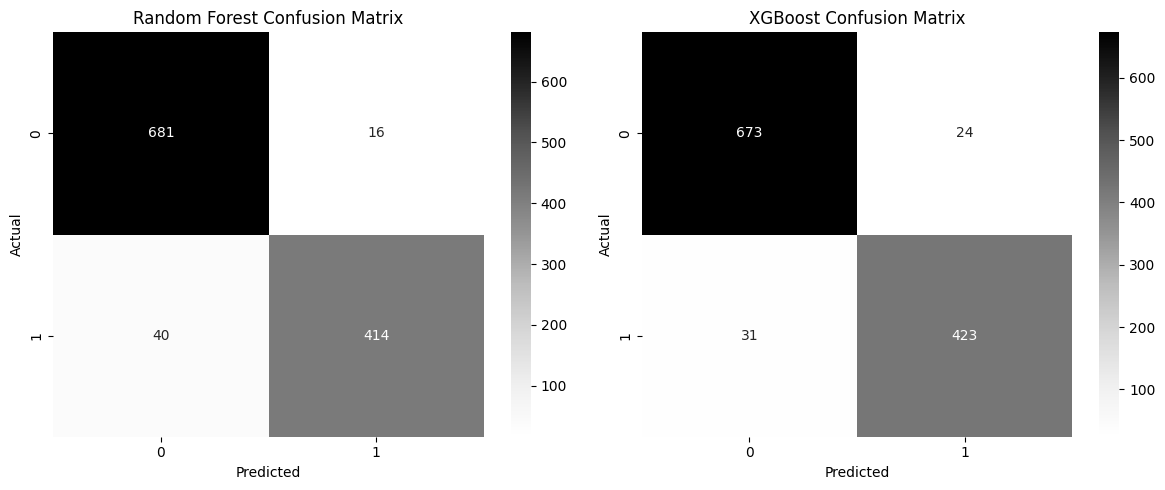

In [17]:
# ------------------------
# Confusion Matrices
# ------------------------
rf_cm = confusion_matrix(y_test, rf_pred)
xgb_cm = confusion_matrix(y_test, xgb_pred)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Random Forest CM
sns.heatmap(rf_cm, annot=True, fmt="d", cmap="Greys", ax=axes[0])
axes[0].set_title("Random Forest Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# XGBoost CM
sns.heatmap(xgb_cm, annot=True, fmt="d", cmap="Greys", ax=axes[1])
axes[1].set_title("XGBoost Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

In [137]:
print("Final Evaluation Results:")
display(final_results)

Final Evaluation Results:


,Model,Accuracy,Precision,Recall,F1 Score
0,Random Forest,0.949609,0.960465,0.909692,0.934389
1,XGBoost,0.952215,0.946309,0.931718,0.938957


In [138]:
# Ensure consistent style
sns.set(style="whitegrid")

# -------------------------------
# Random Forest Feature Importance
# -------------------------------
rf_importance = pd.DataFrame(
    {"Feature": X_train_scaled.columns, "Importance": final_rf.feature_importances_}
).sort_values(by="Importance", ascending=False)


# -------------------------------
# XGBoost Feature Importance
# -------------------------------
xgb_importance = pd.DataFrame(
    {"Feature": X_train_scaled.columns, "Importance": final_xgb.feature_importances_}
).sort_values(by="Importance", ascending=False)


# -----------------------------------
# Combine top features for comparison
# -----------------------------------
top_rf = rf_importance.head(5).assign(Model="RF")
top_xgb = xgb_importance.head(5).assign(Model="XG")

combined_importance = pd.concat([top_rf, top_xgb], ignore_index=True)
display(top_rf)
display(top_xgb)

,Feature,Importance,Model
51,char_freq_!,0.119987,RF
52,char_freq_$,0.105539,RF
6,word_freq_remove,0.075511,RF
15,word_freq_free,0.066384,RF
55,capital_run_length_longest,0.062526,RF


,Feature,Importance,Model
52,char_freq_$,0.179950,XG
6,word_freq_remove,0.110328,XG
51,char_freq_!,0.064046,XG
24,word_freq_hp,0.045605,XG
23,word_freq_money,0.039775,XG


## Conclusion

This project compared several supervised learning models for spam detection using the UCI Spambase dataset, with XGBoost and Random Forest emerging as the top performers. Both models demonstrated strong predictive power, achieving over 95% accuracy and F1-scores above 0.93 on the test set. XGBoost achieved the highest overall F1-score and recall, while Random Forest delivered the highest precision. These results show that tree-based ensemble methods are particularly effective for handling the dataset’s diverse numeric features, capturing nonlinear interactions and subtle text-frequency patterns. Across all metrics, the performance of both models confirms the robustness of ensemble learners for email spam classification.

However, performance metrics must be interpreted in the context of real-world priorities. In spam detection, the more serious error is misclassifying a legitimate (ham) message as spam—a false positive because it can result in important communication being lost or overlooked by the user. In contrast, allowing occasional spam messages into the inbox eg a false negative—is less harmful, as the user can easily delete them. This distinction highlights why precision and false-positive rate are especially important in production spam filters. While XGBoost delivered the strongest balance overall, Random Forest’s slightly higher precision may be preferable in applications where protecting genuine user messages is the top priority. Ultimately, the optimal model depends on the domain’s tolerance for false positives versus false negatives, underscoring the importance of aligning evaluation metrics with practical consequences.

Each model also provided insights into feature importance, revealing which word and character frequency features were most predictive of spam classification. Both XGBoost and Random Forest highlighted terms like "!", "$" and "remove" as top 5 contributors, consistent with domain knowledge about spam content. These insights can inform future feature engineering efforts and help refine spam detection strategies.
Overall, this analysis demonstrates the effectiveness of supervised learning for spam classification and provides a foundation for deploying robust email filtering solutions.This work can also be extended beyond simple spam detection to other forms of email classification, including promotional content, social updates, and even phishing campaigns, since the same supervised learning framework and text-based features apply to a wide range of email filtering tasks.
